# Word2Vec

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('./train/train.csv')

### Clean Data

In [ ]:
import re

# Lowercase and remove punctuation
to_remove = ['.', ',', '?', '!', ':', ';']
replacement = " "

pattern = "|".join(map(re.escape, to_remove))
df["text"] = df["text"].str.replace(pattern, replacement, regex=True)
df["text"] = df["text"].str.lower()

print(df.head())

In [ ]:
# Remove Samples with too Many Words
print(df.shape)
max_words = 100
df = df[df['text'].str.split().apply(len) <= max_words]
print(df.shape)

### Word2Vec

In [ ]:
import gensim
from gensim.models import Word2Vec

data = []

# Tokenize the text data
for i in range(len(df)):
    temp = []
    for j in range(len(df['text'].iloc[i].split())):
        temp.append(df['text'].iloc[i].split()[j])
    data.append(temp)

print(data[:2])

In [ ]:
# Train Word2Vec model
wvmodel = gensim.models.Word2Vec(data, min_count=1,vector_size=100, window=5)

In [ ]:
word1 = 'chicken'
word2 = 'butter'

word_sim = wvmodel.wv.similarity(word1, word2) * 100
word_sim = word_sim

print(f"Similarity between {word1} and {word2}: {word_sim : .2f}%")

In [ ]:
print(wvmodel.wv.most_similar('penetrate', topn=5))

In [ ]:
import gensim.downloader

# Load model
word2vec_model = gensim.downloader.load('glove-wiki-gigaword-100')

In [ ]:
from gensim.utils import simple_preprocess
import torch
from torch.nn.utils.rnn import pad_sequence

tokens_list = []
vectorized_samples = []
kept_samples = []

for i, quote in enumerate(df['text']):
    tokens = simple_preprocess(quote)
    tokens_list.append(tokens)
    word_vectors = [word2vec_model[token] for token in tokens if token in word2vec_model]
    
    # Skip if no valid word vectors , empty or too long
    if len(word_vectors) == 0 or len(word_vectors) > 5000:
        kept_samples.append(False)
        continue
    
    kept_samples.append(True)
    vectorized_samples.append(torch.tensor(word_vectors))

padded_sequence = pad_sequence(vectorized_samples, batch_first=True)
print(f"Padded sequence shape: {padded_sequence.shape}")
print(f"Kept {len(vectorized_samples)} out of {len(df)} samples")
print(f"First sample shape: {padded_sequence[0].shape}")

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import math
from PositionalEncoding import PositionalEncoding

class TransformerModel(nn.Transformer):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, noutput, dropout=0.3):
        super(TransformerModel, self).__init__(d_model=ninp, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers)
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)

        self.input_emb = nn.TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.ninp = ninp
        self.flatten = nn.Flatten()
        self.decoder = nn.Linear(ninp * ntoken, noutput)
        self.softmax = nn.Softmax(dim=1)

    def _generate_square_subsequent_mask(self, sz):
        return torch.log(torch.tril(torch.ones(sz,sz)))

    def forward(self, src, has_mask=True):
        if has_mask:
            device = src.device
            if self.src_mask is None or self.src_mask.size(0) != len(src):
                mask = self._generate_square_subsequent_mask(len(src)).to(device)
                self.src_mask = mask
        else:
            self.src_mask = None

        src = self.input_emb(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.encoder(src, mask=self.src_mask)
        output = self.flatten(output)
        output = self.decoder(output)
        return F.log_softmax(output, dim=-1)

In [ ]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

X = padded_sequence.to(device)
encoder = LabelEncoder()
y = encoder.fit_transform(df['author'][kept_samples].values.reshape(-1, 1))
y = torch.tensor(y, dtype=torch.long).to(device)
dataset = TensorDataset(X, y)
model = TransformerModel(X.shape[1], ninp=100, nhead=5, nhid=512, nlayers=3, noutput=3, dropout=0.3).to(device)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.2, 0.1])


def objective(trial):
    """Optuna objective function to minimize validation loss"""
    
    # Suggest hyperparameters
    nhid = trial.suggest_int('nhid', 128, 768, step=128)  # 128, 256, 384, 512, 640, 768
    nlayers = trial.suggest_int('nlayers', 1, 4)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)
    
    # Create datasets with suggested batch size
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Create model with suggested hyperparameters
    model = TransformerModel(
        X.shape[1], 
        ninp=100,  # Keep embedding size fixed
        nhead=5,   # Keep nhead fixed (must divide ninp)
        nhid=nhid, 
        nlayers=nlayers, 
        noutput=3, 
        dropout=dropout
    ).to(device)
    
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    num_epochs = 50
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            outputs = model.forward(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                outputs = model.forward(X_batch, has_mask=False)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_dataloader)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
        
        # Report intermediate value for pruning
        trial.report(val_loss, epoch)
        
        # Handle pruning
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return best_val_loss

# Create study and optimize
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)

print("Starting hyperparameter optimization...")
study.optimize(objective, n_trials=50, timeout=7200)

# Print results
print(f"Best trial: {study.best_trial.number}")
print(f"Best validation loss: {study.best_value:.4f}")
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

In [ ]:
# Visualize optimization history
fig = plot_optimization_history(study)
fig.show()

# Visualize parameter importance
fig = plot_param_importances(study)
fig.show()

# Show all trials
trials_df = study.trials_dataframe()
print("\nAll trials:")
print(trials_df[['number', 'value', 'params_nhid', 'params_nlayers', 'params_dropout', 'params_lr', 'params_batch_size']].sort_values('value'))

c:\Users\supak\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Training with early stopping (patience=15)...



  5%|▌         | 5/100 [00:16<05:17,  3.34s/it]

Epoch 5/100 - Train: 0.6925, Val: 0.7579, LR: 0.001594, Patience: 1/15


 10%|█         | 10/100 [00:33<04:58,  3.31s/it]

Epoch 10/100 - Train: 0.5217, Val: 0.5993, LR: 0.001594, Patience: 0/15


 15%|█▌        | 15/100 [00:50<04:41,  3.31s/it]

Epoch 15/100 - Train: 0.4371, Val: 0.6229, LR: 0.001594, Patience: 3/15


 20%|██        | 20/100 [01:06<04:25,  3.31s/it]

Epoch 20/100 - Train: 0.3048, Val: 0.6255, LR: 0.000797, Patience: 2/15


 25%|██▌       | 25/100 [01:23<04:08,  3.32s/it]

Epoch 25/100 - Train: 0.2248, Val: 0.6835, LR: 0.000399, Patience: 7/15


 30%|███       | 30/100 [01:39<03:53,  3.33s/it]

Epoch 30/100 - Train: 0.1767, Val: 0.7239, LR: 0.000100, Patience: 12/15


 32%|███▏      | 32/100 [01:49<03:53,  3.43s/it]


Early stopping triggered at epoch 33
Best validation loss: 0.5708

Loading best model from epoch 18


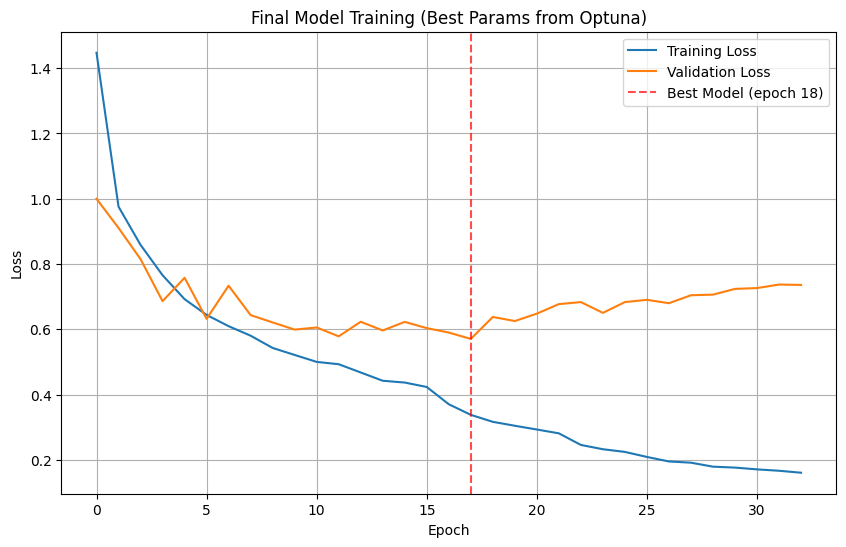


Best validation loss: 0.5708
Training stopped at epoch: 33
Best model saved at epoch: 18


In [26]:
from tqdm import tqdm

# Train final model with best hyperparameters
best_params = study.best_params

# Create final model
final_model = TransformerModel(
    X.shape[1], 
    ninp=100, 
    nhead=5, 
    nhid=best_params['nhid'], 
    nlayers=best_params['nlayers'], 
    noutput=3, 
    dropout=best_params['dropout']
).to(device)

# Create dataloaders with best batch size
final_train_dataloader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
final_val_dataloader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(
    final_model.parameters(), 
    lr=best_params['lr'], 
    weight_decay=best_params['weight_decay']
)

# Scheduler decresases LR as val_loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early stopping parameters
num_epochs = 100
training_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 15
patience_counter = 0

print(f"Training with early stopping (patience={patience})...\n")

for epoch in tqdm(range(num_epochs)):
    # Training
    final_model.train()
    train_loss = 0
    for X_batch, y_batch in final_train_dataloader:
        optimizer.zero_grad()
        outputs = final_model.forward(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(final_model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(final_train_dataloader)
    training_losses.append(train_loss)
    
    # Validation
    final_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in final_val_dataloader:
            outputs = final_model.forward(X_batch, has_mask=False)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_loss /= len(final_val_dataloader)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        # Saves the best model
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(final_model.state_dict(), "transformer_model_best_optuna.pt")
    else:
        patience_counter += 1
        # Trigger early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.4f}")
            break
    
    if (epoch + 1) % 5 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1}/{num_epochs} - Train: {train_loss:.4f}, Val: {val_loss:.4f}, LR: {current_lr:.6f}, Patience: {patience_counter}/{patience}')

# Load best model
print(f"\nLoading best model from epoch {len(val_losses) - patience_counter}")
final_model.load_state_dict(torch.load("transformer_model_best_optuna.pt"))

# Plot final results
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
best_epoch = val_losses.index(min(val_losses))
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best Model (epoch {best_epoch+1})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Final Model Training (Best Params from Optuna)')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nBest validation loss: {best_val_loss:.4f}")
print(f"Training stopped at epoch: {len(val_losses)}")
print(f"Best model saved at epoch: {best_epoch+1}")

In [38]:
# Validate Model
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
correct = 0
total = 0
final_model.eval()
with torch.no_grad():
    for X_batch, y_batch in val_dataloader:
        outputs = final_model.forward(X_batch, has_mask=False)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
print(f'Validation Accuracy: {100 * correct / total : .2f}%')

Validation Accuracy:  78.37%


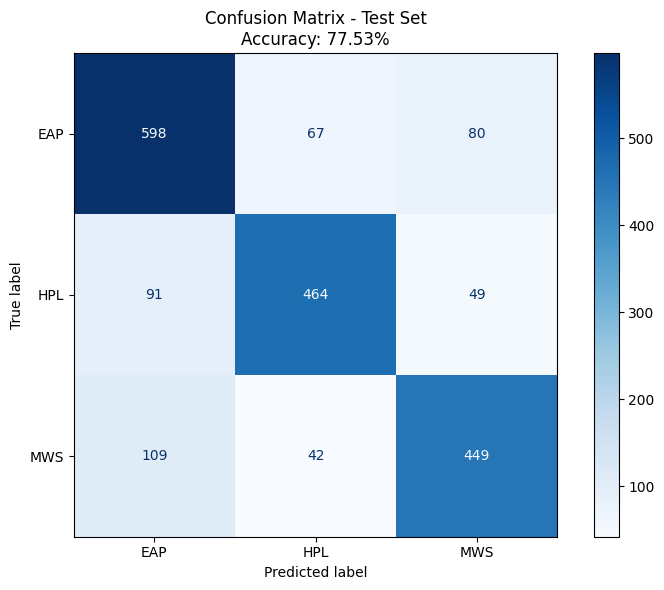


Classification Report:
              precision    recall  f1-score   support

         EAP       0.75      0.80      0.78       745
         HPL       0.81      0.77      0.79       604
         MWS       0.78      0.75      0.76       600

    accuracy                           0.78      1949
   macro avg       0.78      0.77      0.78      1949
weighted avg       0.78      0.78      0.78      1949


Test Accuracy: 77.53%


In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
y_pred = []
y_actual = []

# Make predictions on test set
final_model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        outputs = final_model.forward(X_batch, has_mask=False)
        _, predicted = torch.max(outputs, 1)
        
        y_pred.extend(predicted.cpu().numpy())
        y_actual.extend(y_batch.cpu().numpy())

# Calculate test accuracy
test_accuracy = 100 * sum([1 for i, j in zip(y_pred, y_actual) if i == j]) / len(y_actual)

# Create confusion matrix
cm = confusion_matrix(y_actual, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title(f'Confusion Matrix - Test Set\nAccuracy: {test_accuracy:.2f}%')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_actual, y_pred, target_names=encoder.classes_))
print(f"\nTest Accuracy: {test_accuracy:.2f}%")